In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns
import catboost
from catboost import CatBoostClassifier, Pool, cv
import shap
shap.initjs()

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [46]:
data = pd.read_csv('data/all_data.csv', sep=',')
data = data.drop(['brow_a', 'brow_b', 'brow_c', 'brow_d'], axis=1)
data_norm = data.copy()
for col in tqdm(data.columns[:-1]):
    data_norm[col] = (data_norm[col] - data_norm[col].quantile(0.01)) / (data_norm[col].quantile(0.99) - data_norm[col].quantile(0.001))
    

  0%|          | 0/19 [00:00<?, ?it/s]

In [47]:
train_cols = ['Высота бровей', 'Наклон глаз',
               'Полнота верхней губы', 'Полнота нижней губы',
               'Ширина посадки глаз', 'Скулы',
               'Форма головы', 'Верхнее веко', 'Наклон бровей',
               'Размер рта', 'Размер глаз', 'Ширина челюсти']

X = data_norm[train_cols]
y = data_norm['Class']

In [48]:
X.shape

(3188, 12)

In [49]:
y.value_counts()

human      1716
warrior    1472
Name: Class, dtype: int64

In [96]:
cv_dataset = Pool(data=X,
                  label=y)

params = {"iterations": 300,
          "learning_rate":0.2,
          "depth": 5,
          "loss_function": "Logloss",
          "verbose": False,
          "eval_metric": "AUC"}

scores = cv(cv_dataset,
            params,
            fold_count=10, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [106]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from matplotlib import pyplot
from sklearn.metrics import auc, roc_curve
model = LogisticRegression()
model.fit(X, (y == 'warrior').astype(int).values)
y_proba = model.predict_proba(X)#, (y == 'warrior').astype(int).values)

fpr, tpr, thresholds = roc_curve((y == 'warrior').astype(int).values, y_proba[:,0], pos_label=0)
auc(fpr, tpr)

0.8268870509019964

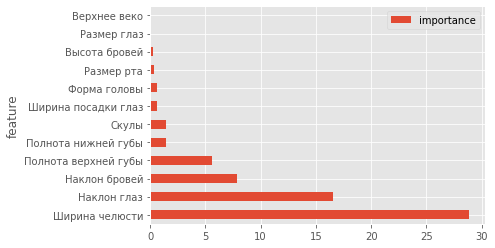

In [107]:
import math
feature_importance = pd.DataFrame(X.columns, columns = ["feature"])
feature_importance["importance"] = pow(math.e, model.coef_[0])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

In [108]:
from sklearn.model_selection import cross_val_score
clf = LogisticRegression()


scores = cross_val_score(model, X, (y == 'warrior').astype(int).values, cv=10, scoring='roc_auc')
scores.mean()

0.822697903983968

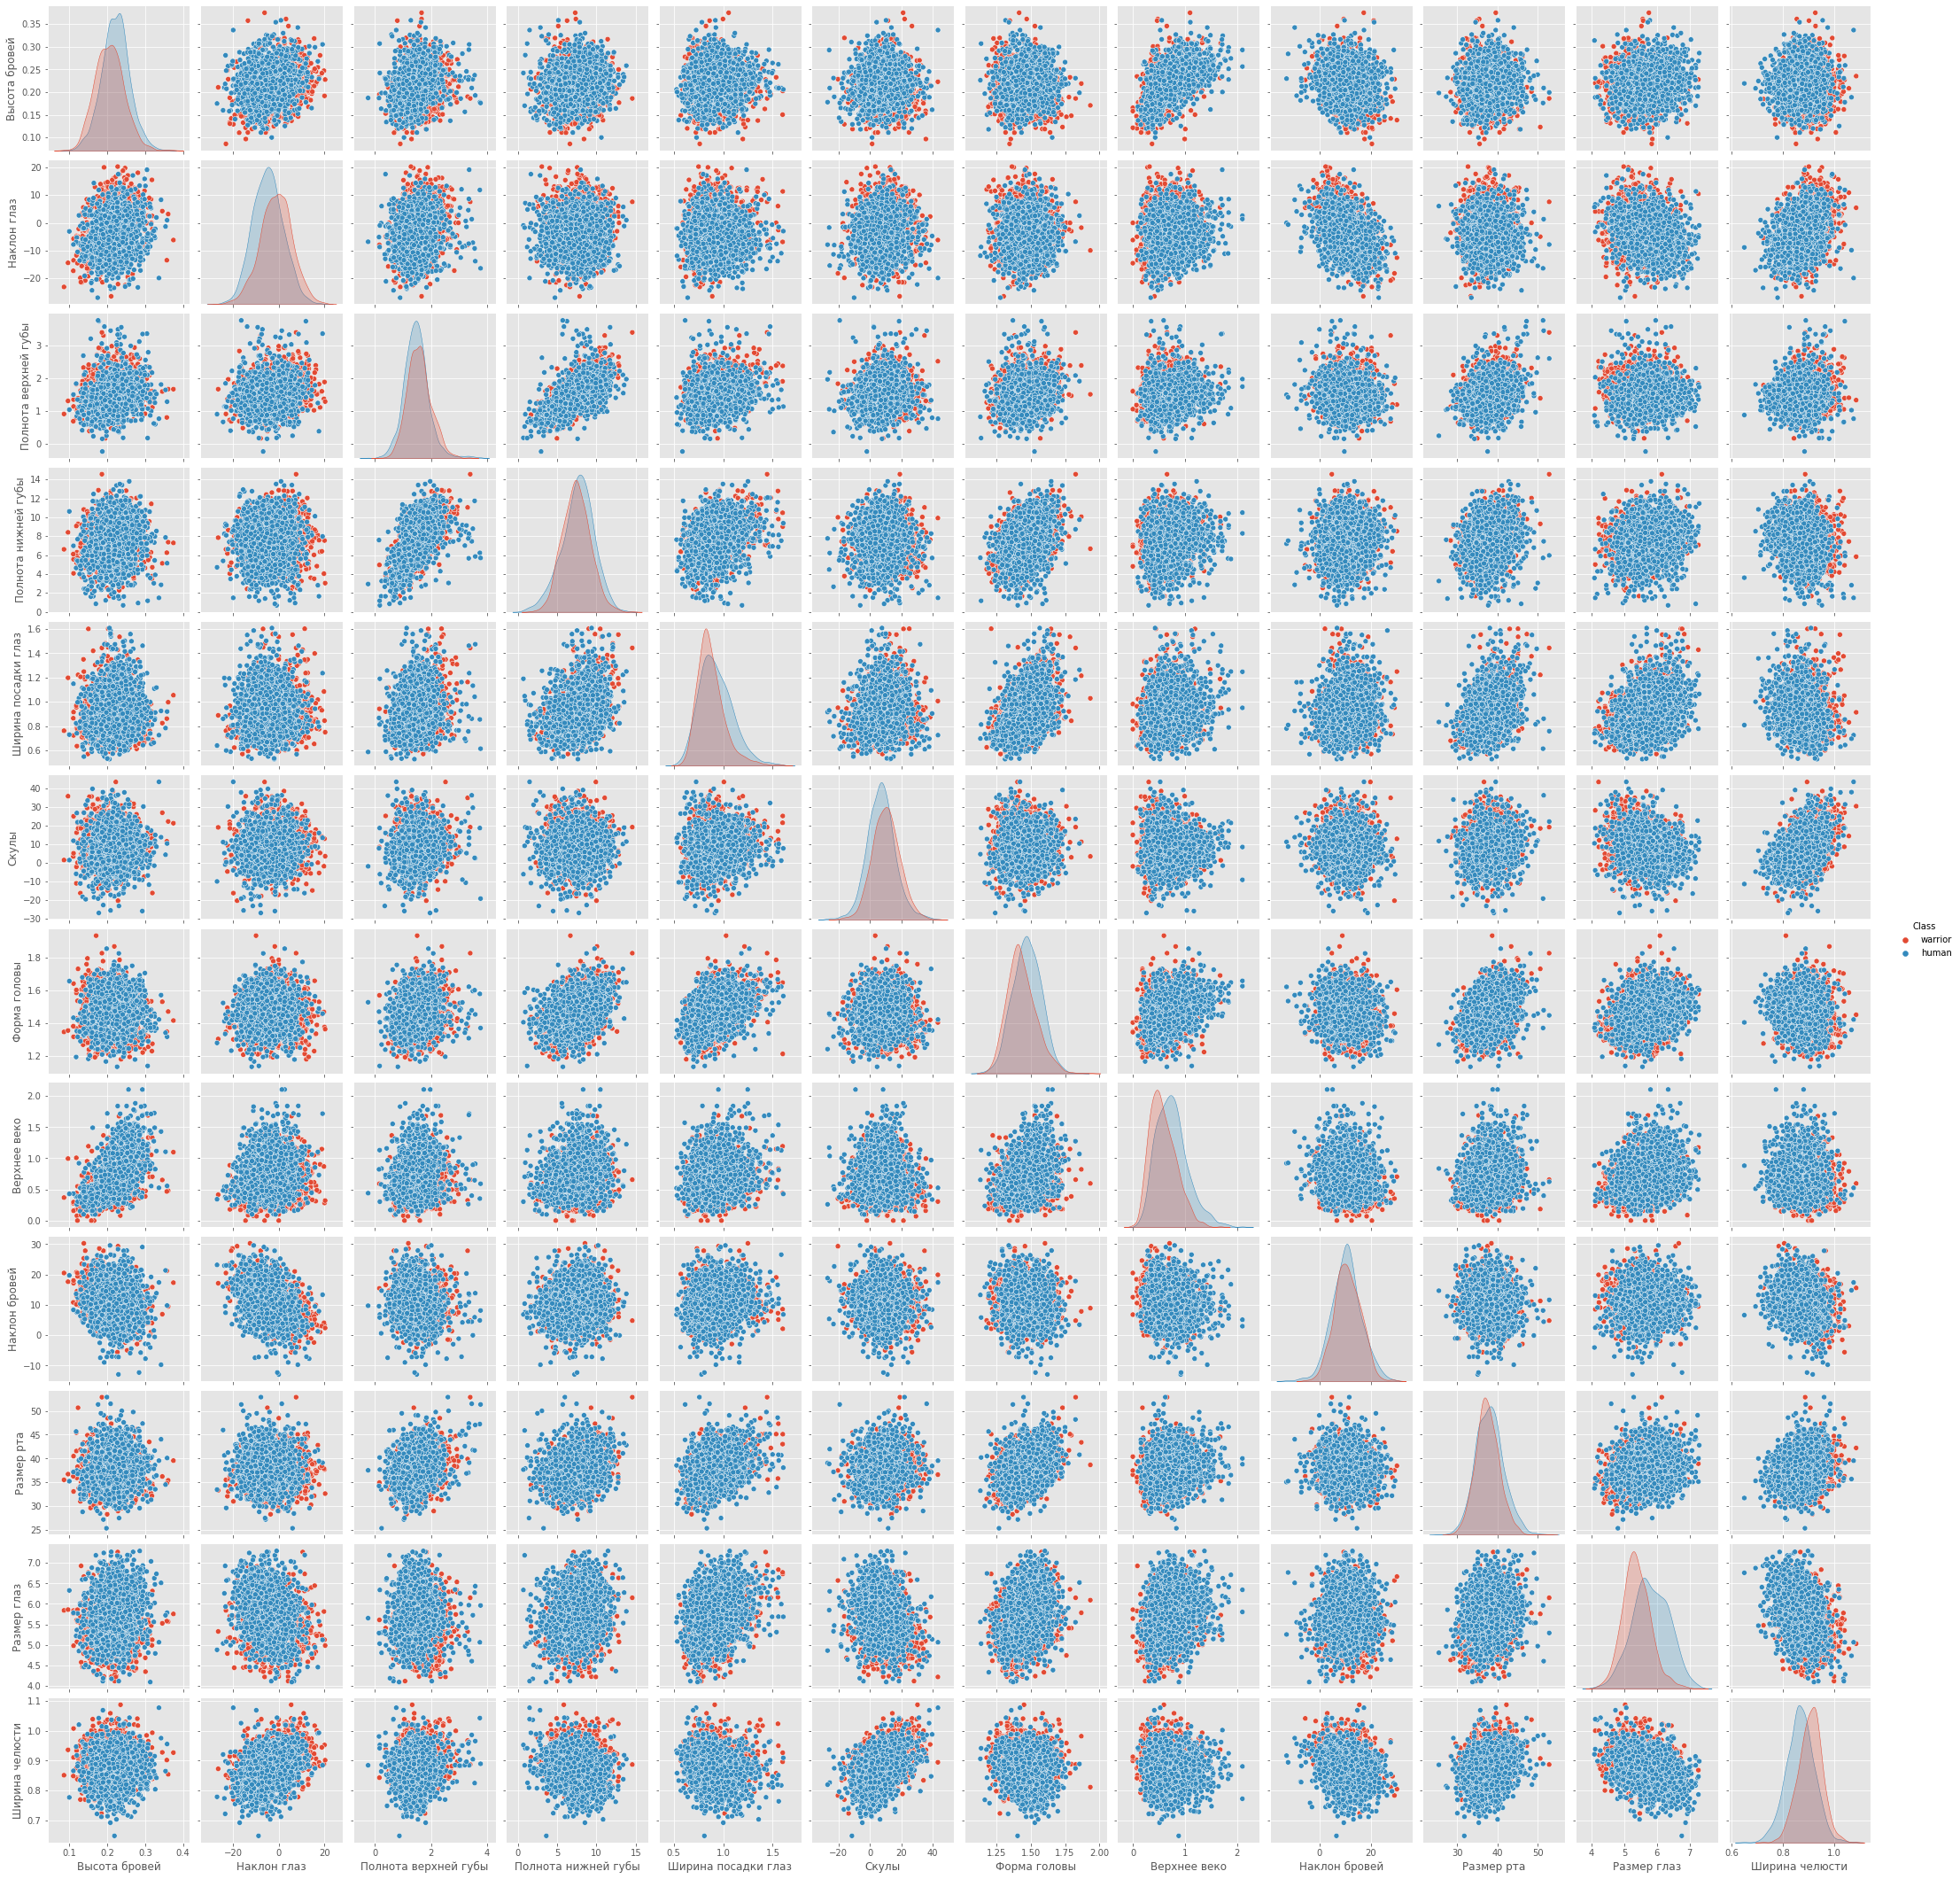

In [113]:
sns.pairplot(data, hue='Class', vars=train_cols)

In [114]:
model = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.2, random_seed=12)
model.fit(X, y, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/home/nikolay/anaconda3/envs/peller/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.

/home/nikolay/anaconda3/envs/peller/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.



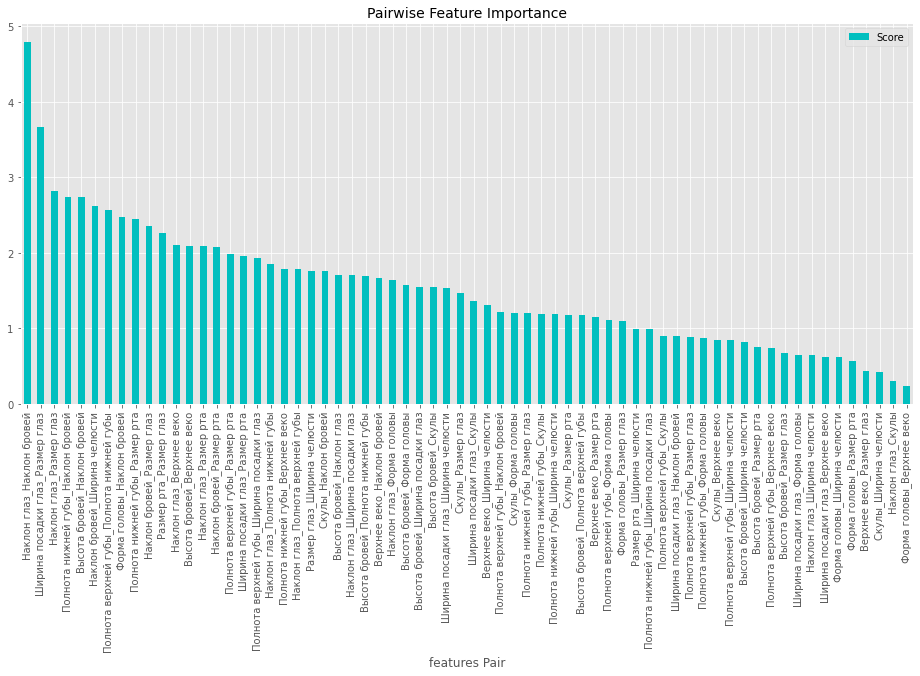

In [121]:
fi = model.get_feature_importance(Pool(X, label=y), type="Interaction")

fi_new = []
for k,item in enumerate(fi):  
    first = X.dtypes.index[fi[k][0]]
    second = X.dtypes.index[fi[k][1]]
    if first != second:
        fi_new.append([first + "_" + second, fi[k][2]])
        
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c', orientation='vertical')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()



In [99]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [100]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [101]:
shap.force_plot(explainer.expected_value, shap_values[:50,:], X.iloc[:50,:])

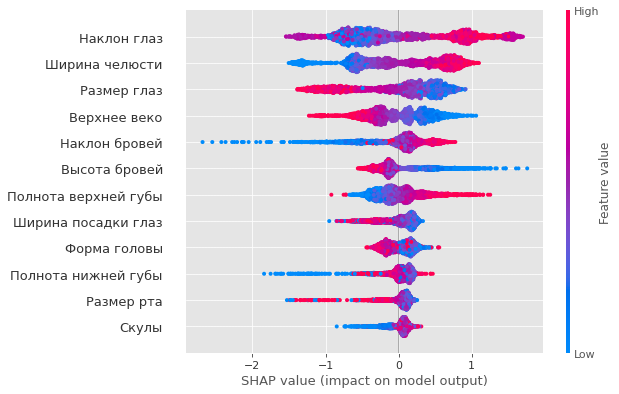

In [102]:
shap.summary_plot(shap_values, X)